# 1. Modern Regularization Techniques
We are now going to look at modern regularization techniques such as drop out. Dropout is a technique developed by Geoff Hinton and team. Up until we have worked with the following types of regularization:

<br>
## 1.1 L1 and L2 Regularization
**L1 regularization** encourages weights to be sparse, aka most weights being equal to 0. **L2 regularization** encourages most weights to be small, aka approximately equal to 0. 

$$L_{regularized} = L_{likelihood} + \lambda|\theta|^p$$

<br>
## 1.2 Dropout 
In contrast to L1 and L2 regularization, **Dropout** does not add any penalty term to the cost. Instead, it works in a totally different way. Specifically, dropout works by dropping random nodes in the neural network during training. This has the effect of making it so that any hidden layer unit cannot just rely on 1 input feature, because at any time that node could be dropped. 

<img src="images/dropout.png">

We will see that dropout emulates an ensemble of neural networks. What exactly is meant by ensemble? Well, remember how we mentioned we would be dropping some nodes in the neural network. We can imagine that instead of just randomly dropped nodes during training, we could actually create several instances of neural networks with these different structures and train them all. Then, to calculate the final prediction, we could average the predictions of each individual neural network. 

<br>
**Pseudocode**
```
prediction1 = neuralNetwork1.predict(X)
prediction2 = neuralNetwork2.predict(X)
prediction3 = neuralNetwork3.predict(X)

finalPrediction = mean(prediction1, prediction2, prediction3)
```

---

<br>
# 2. Dropout 
We are now going to dig further to see exactly how dropping nodes randomly in a neural network performs regularization, and how it emulates an ensemble of neural networks. 

<br>
### 2.0 Ensembles  
First, let's quickly discuss ensembles. The basic idea is that by using a group of prediction models that are different, and then taking the average or a majority vote we can end up with better accuracy than if we had just used 1 prediction model. So, what do we mean by different? 

<br>
**Method 1**
<br>
One easy way is to just train on different subsets of random data. This is also good if your algorithm doesn't scale. As an example, say you have 1 million training points, but you train 10 different versions of a decision tree on only 100,000 points, then that would be an ensemble of decision trees. Then, to get a prediction you take a majority vote from these 10 different decision trees. 

<br>
**Method 2**
<br>
Another method is to not use all of the features. So, if we have 100 features, maybe each of the 10 decision trees will only look at 10 different features each. The result is that instead of training 1 decision tree on a 1 million x 100 matrix X matrix, we train 10 decision trees on 100k x 10 matrices, which are all sampled from the original matrix. Miraculously, this results in better performance that just training 1 decision tree. Dropout is more like this method. 

---

<br>
## 2.1 Dropout
So, how exactly does dropout work? Well, as we said, we are only going to use a subset of features. However, we are not only going to do this at the input layer, we are going to do this at every layer. At every layer, we are going to choose randomly which nodes to drop. We use a probability $p(drop)$ or $p(keep)$ to tell us the probability of dropping or keeping a node. Typical values of $p(keep)$ are 0.8 for the input layer, and 0.5 for the hidden layers. 

Note, we only drop layers during training. Also, notice that when we discussed ensembling there were 10 decision trees. However, with dropout there is still only 1 neural network. This is because we have only talked about training up until now. The other part is of course prediction. 

### 2.1.1 Dropout - Prediction
The way that we do prediction is that instead of dropping nodes, we multiply the output of a layer by its $p(keep)$. This effectively shrinks all of the values at that layer. In a way, that is similar to what L2 regularization does. It makes all of the weights smaller so that effectively all of the values are smaller. 

<br>
**Pseudocode**
<br>
```
# Prediciton
# If we have 1 hidden layer: X -> Y -> Z
X_drop = p(keep | layer1) * X
Z = f(X_drop.dot(W) + b)
Z_drop = p(keep | layer2) * Z
Y = softmax(Z_drop.dot(V) + c)

# So we can see that we are multiplying by the p(keep) at that layer
# This shrinks the value. L2 regularization also encourages weights to be small,
# Leading to shrunken values
```

Let's think about what this ensemble represents. If we have in total $N$ nodes in the neural network, that is just:

$$N = number \; input \; nodes + number \; hidden \; nodes$$

Each of these nodes can have 2 states: **On** or **Off**, **Drop** or **Keep**. So, that means in total we have:

$$possible \; neural \; networks = 2^N$$

Therefore, we are approximating an ensemble of $2^N$ different neural networks. Now, imagine the case where you were not doing an approximation. Let's take a very small neural network, only 100 nodes (N = 100). Keep in mind that is a very small neural net. For comparison, MNIST would have ~1000 nodes total; 700 for the input and 300 for the hidden layer. Anyways, if we only had 100 nodes, we would still have:

$$2^{100} \approx 1.3 * 10^{30}$$

Imagine training that many neural nets? It would clearly be infeasible. So, we can't actually do that ensemble, however, mutliplying by $p(keep)$ allows us to approximate it. 

---
<br>
## 2.2 Dropout - Implementation Theano
The basic approach in theano to implement dropout, instead of actually dropping nodes out of the neural network, which would result in a different computational graph which theano wouldn't be able to handle, we are instead just going to multiply by 0. This has the same effect as dropping a node, because anything that comes after it will be mutliplied by 0 which is still 0. Since at each layer we are going to have an $N x D$ matrix, where N is equal to the batch size, we need to create an $N x D$ matrix of 0s and 1s to multiply that layer by. We call this matrix a **mask**. 

Now, recall that when you define the computational graph in theano you are not using real values. You are just specifying which nodes are connected to which other nodes. This means that we cannot multiply by a random numpy matrix in there, because that is effectively constant. If we randomly generate a 1 in the theano graph, and it is a numpy 1, then it is always going to be a 1 when we call the theano function to get the output of that graph. So, this would not work:

<br>
**Incorrect Pseudocode**
<br>
```
mask = np.random.binomial(...)
Z = f((X * mask).dot(W) + b) 
```

Instead, what we want to do is have theano generate random numbers every time it passes through the graph. In order to do that we need an ojbect called random streams. Now, instead of passing an input directly to a hidden layer, we will first multiply it by a mask, which is equivalent to dropping some nodes. We then multiply by the weight and add the bias. 

<br>
**Correct Pseudocode**
<br>
```
from theano.tensor.shared_randomstreams import RandomStreams
rng = RandomStreams()
mask = rng.binomial(n=1, p=p_keep, size=X.shape)
X_drop = mask * X
```

<br>
### 2.2.1 Dropout - Implementation Theano Code 

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from theano.tensor.shared_randomstreams import RandomStreams      # Import Random Streams
from util import get_normalized_data
from sklearn.utils import shuffle

"""
HiddenLayer class that knows nothing about dropout
"""
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)


class ANN(object):
    # Constructor now takes in p_keep - this is a list of probabilities since each layer 
    # can have its own probability of keeping 
    def __init__(self, hidden_layer_sizes, p_keep):     
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep

    def fit(self, X, Y, learning_rate=1e-4, mu=0.9, decay=0.9, epochs=8, 
            batch_sz=100, show_fig=False):
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        self.rng = RandomStreams()          # Creating object of type RandomStreams

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = np.random.randn(M1, K) * np.sqrt(2.0 / M1)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY_train = self.forward_train(thX)     # Updates are defined using forward_train
                                               # since dropping nodes occurs during training

        # this cost is for training
        cost = -T.mean(T.log(pY_train[T.arange(thY.shape[0]), thY]))

        # gradients wrt each param
        grads = T.grad(cost, self.params)

        # for momentum
        dparams = [theano.shared(np.zeros_like(p.get_value())) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.ones_like(p.get_value())) for p in self.params]

        new_cache = [decay*c + (1-decay)*g*g for p, c, g in zip(self.params, cache, grads)]
        new_dparams = [mu*dp - learning_rate*g/T.sqrt(new_c + 1e-10) for p, new_c, dp, g in zip(self.params, new_cache, dparams, grads)]
        updates = [
            (c, new_c) for c, new_c in zip(cache, new_cache)
        ] + [
            (dp, new_dp) for dp, new_dp in zip(dparams, new_dparams)
        ] + [
            (p, p + new_dp) for p, new_dp in zip(self.params, new_dparams)
        ]

        # momentum only
        # updates = [
        #     (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ] + [
        #     (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        # for evaluation and prediction
        pY_predict = self.forward_predict(thX)
        cost_predict = -T.mean(T.log(pY_predict[T.arange(thY.shape[0]), thY]))
        prediction = self.predict(thX)
        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost_predict, prediction])

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if j % 20 == 0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    """
    Instead of forward function, we now have forward train function, and forward 
    predict function. This is because dropout acts differently during training and prediction.
    During forward_train nodes are dropped. During forward_predict nodes are not dropped. 
    """
    def forward_train(self, X):
      """
      We are generating a mask using the random streams object. We pass in n=1, meaning it 
      is like doing one coin flip, the probability of 1 is p_keep, and the size should be 
      the same size as what we are about to multiply by. This is done at every layer, and 
      then we do the softmax layer. 
      """
      Z = X
      for h, p in zip(self.hidden_layers, self.dropout_rates[:-1]):
          mask = self.rng.binomial(n=1, p=p, size=Z.shape)
          Z = mask * Z
          Z = h.forward(Z)
      mask = self.rng.binomial(n=1, p=self.dropout_rates[-1], size=Z.shape)
      Z = mask * Z
      return T.nnet.softmax(Z.dot(self.W) + self.b)

    def forward_predict(self, X):
      """
      Here there is no mask. We just multiply each layer by its p_keep value. This is why 
      it is convenient to use the probability of keep instead of the probability of drop. 
      Since we can use p_keep directly in all cases. 
      """
      Z = X
      for h, p in zip(self.hidden_layers, self.dropout_rates[:-1]):
          Z = h.forward(p * Z)
      return T.nnet.softmax((self.dropout_rates[-1] * Z).dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward_predict(X)
        return T.argmax(pY, axis=1)


def error_rate(p, t):
    return np.mean(p != t)


def relu(a):
    return a * (a > 0)


def main():
    # step 1: get the data and define all the usual variables
    X, Y = get_normalized_data()

    ann = ANN([500, 300], [0.8, 0.5, 0.5])
    ann.fit(X, Y, show_fig=True)


if __name__ == '__main__':
    main()

Reading in and transforming data...
i: 0 j: 0 nb: 410 cost: 2.337057573018881 error rate: 0.915
i: 0 j: 20 nb: 410 cost: 2.331484547251978 error rate: 0.911
i: 0 j: 40 nb: 410 cost: 2.3124086200940535 error rate: 0.893
i: 0 j: 60 nb: 410 cost: 2.261491745234726 error rate: 0.814
i: 0 j: 80 nb: 410 cost: 2.1338191867754883 error rate: 0.582
i: 0 j: 100 nb: 410 cost: 1.8422713999612295 error rate: 0.385
i: 0 j: 120 nb: 410 cost: 1.2693874568110737 error rate: 0.253
i: 0 j: 140 nb: 410 cost: 0.7049998054679623 error rate: 0.156
i: 0 j: 160 nb: 410 cost: 0.45281047762950005 error rate: 0.123
i: 0 j: 180 nb: 410 cost: 0.3850782603105124 error rate: 0.117
i: 0 j: 200 nb: 410 cost: 0.3391346422886878 error rate: 0.095
i: 0 j: 220 nb: 410 cost: 0.30524064571316234 error rate: 0.086
i: 0 j: 240 nb: 410 cost: 0.29850151868999425 error rate: 0.086
i: 0 j: 260 nb: 410 cost: 0.285784098990031 error rate: 0.085
i: 0 j: 280 nb: 410 cost: 0.2689050036430372 error rate: 0.085
i: 0 j: 300 nb: 410 cost: 

i: 6 j: 80 nb: 410 cost: 0.13673599601656233 error rate: 0.036
i: 6 j: 100 nb: 410 cost: 0.1394754231415506 error rate: 0.036
i: 6 j: 120 nb: 410 cost: 0.13160281082404487 error rate: 0.034
i: 6 j: 140 nb: 410 cost: 0.13618343530963395 error rate: 0.035
i: 6 j: 160 nb: 410 cost: 0.12634420666489482 error rate: 0.037
i: 6 j: 180 nb: 410 cost: 0.12636038318859463 error rate: 0.035
i: 6 j: 200 nb: 410 cost: 0.1332823131990901 error rate: 0.037
i: 6 j: 220 nb: 410 cost: 0.13164134987988207 error rate: 0.035
i: 6 j: 240 nb: 410 cost: 0.12421922440203884 error rate: 0.031
i: 6 j: 260 nb: 410 cost: 0.1273826703892371 error rate: 0.031
i: 6 j: 280 nb: 410 cost: 0.12263275911146586 error rate: 0.033
i: 6 j: 300 nb: 410 cost: 0.12412997635347965 error rate: 0.031
i: 6 j: 320 nb: 410 cost: 0.12565616318061681 error rate: 0.035
i: 6 j: 340 nb: 410 cost: 0.1252585120865418 error rate: 0.035
i: 6 j: 360 nb: 410 cost: 0.12595065580154965 error rate: 0.034
i: 6 j: 380 nb: 410 cost: 0.12066781499789525

---

<br>
# 3. Dropout - Implementation TensorFlow Code

Reading in and transforming data...
epoch: 0 n_batches: 410
i: 0 j: 0 nb: 410 cost: 2.6843886 error rate: 0.875
i: 0 j: 20 nb: 410 cost: 2.448834 error rate: 0.841
i: 0 j: 40 nb: 410 cost: 2.0336432 error rate: 0.692
i: 0 j: 60 nb: 410 cost: 1.435119 error rate: 0.419
i: 0 j: 80 nb: 410 cost: 0.9270588 error rate: 0.267
i: 0 j: 100 nb: 410 cost: 0.63800913 error rate: 0.188
i: 0 j: 120 nb: 410 cost: 0.4701906 error rate: 0.135
i: 0 j: 140 nb: 410 cost: 0.39445698 error rate: 0.112
i: 0 j: 160 nb: 410 cost: 0.34497428 error rate: 0.099
i: 0 j: 180 nb: 410 cost: 0.33794552 error rate: 0.096
i: 0 j: 200 nb: 410 cost: 0.28414965 error rate: 0.086
i: 0 j: 220 nb: 410 cost: 0.28230405 error rate: 0.092
i: 0 j: 240 nb: 410 cost: 0.27701184 error rate: 0.087
i: 0 j: 260 nb: 410 cost: 0.28214195 error rate: 0.089
i: 0 j: 280 nb: 410 cost: 0.25912136 error rate: 0.079
i: 0 j: 300 nb: 410 cost: 0.26421338 error rate: 0.088
i: 0 j: 320 nb: 410 cost: 0.26033127 error rate: 0.071
i: 0 j: 340 nb: 410

i: 7 j: 20 nb: 410 cost: 0.10944215 error rate: 0.03
i: 7 j: 40 nb: 410 cost: 0.10805051 error rate: 0.029
i: 7 j: 60 nb: 410 cost: 0.094569765 error rate: 0.028
i: 7 j: 80 nb: 410 cost: 0.108169876 error rate: 0.025
i: 7 j: 100 nb: 410 cost: 0.10601462 error rate: 0.029
i: 7 j: 120 nb: 410 cost: 0.098070525 error rate: 0.025
i: 7 j: 140 nb: 410 cost: 0.101992145 error rate: 0.029
i: 7 j: 160 nb: 410 cost: 0.105933 error rate: 0.029
i: 7 j: 180 nb: 410 cost: 0.09671913 error rate: 0.026
i: 7 j: 200 nb: 410 cost: 0.09793087 error rate: 0.026
i: 7 j: 220 nb: 410 cost: 0.10490563 error rate: 0.029
i: 7 j: 240 nb: 410 cost: 0.1071707 error rate: 0.029
i: 7 j: 260 nb: 410 cost: 0.11151346 error rate: 0.031
i: 7 j: 280 nb: 410 cost: 0.11077808 error rate: 0.032
i: 7 j: 300 nb: 410 cost: 0.098634645 error rate: 0.026
i: 7 j: 320 nb: 410 cost: 0.09915872 error rate: 0.029
i: 7 j: 340 nb: 410 cost: 0.09714603 error rate: 0.025
i: 7 j: 360 nb: 410 cost: 0.09970877 error rate: 0.021
i: 7 j: 380 n

i: 14 j: 0 nb: 410 cost: 0.103458144 error rate: 0.025
i: 14 j: 20 nb: 410 cost: 0.11584638 error rate: 0.03
i: 14 j: 40 nb: 410 cost: 0.110724546 error rate: 0.025
i: 14 j: 60 nb: 410 cost: 0.1123889 error rate: 0.024
i: 14 j: 80 nb: 410 cost: 0.09920174 error rate: 0.026
i: 14 j: 100 nb: 410 cost: 0.10753195 error rate: 0.028
i: 14 j: 120 nb: 410 cost: 0.11063557 error rate: 0.033
i: 14 j: 140 nb: 410 cost: 0.11771754 error rate: 0.03
i: 14 j: 160 nb: 410 cost: 0.12957485 error rate: 0.03
i: 14 j: 180 nb: 410 cost: 0.10281798 error rate: 0.028
i: 14 j: 200 nb: 410 cost: 0.09882788 error rate: 0.029
i: 14 j: 220 nb: 410 cost: 0.10134557 error rate: 0.029
i: 14 j: 240 nb: 410 cost: 0.09583875 error rate: 0.026
i: 14 j: 260 nb: 410 cost: 0.10813488 error rate: 0.026
i: 14 j: 280 nb: 410 cost: 0.11340303 error rate: 0.024
i: 14 j: 300 nb: 410 cost: 0.10826114 error rate: 0.025
i: 14 j: 320 nb: 410 cost: 0.1022352 error rate: 0.026
i: 14 j: 340 nb: 410 cost: 0.09387094 error rate: 0.026
i

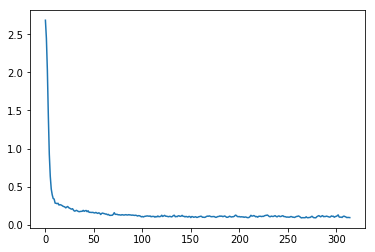

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from util import get_normalized_data
from sklearn.utils import shuffle

"""HiddenLayer class that knows nothing about dropout"""
class HiddenLayer(object):
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
        b = np.zeros(M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

"""ANN class takes in p_keep. Everything proceeds as normal until we get to forward train"""
class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep

    def fit(self, X, Y, lr=1e-4, mu=0.9, decay=0.9, epochs=15, batch_sz=100, split=True, print_every=20):
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int64)
        if split:
            Xvalid, Yvalid = X[-1000:], Y[-1000:]
            X, Y = X[:-1000], Y[:-1000]
        else:
            Xvalid, Yvalid = X, Y

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W = np.random.randn(M1, K) * np.sqrt(2.0 / M1)
        b = np.zeros(K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        inputs = tf.placeholder(tf.float32, shape=(None, D), name='inputs')
        labels = tf.placeholder(tf.int64, shape=(None,), name='labels')
        logits = self.forward(inputs)

        """Remember that tensorflow does softmax for us, so we only need to get logits"""
        cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=labels
            )
        )
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        # train_op = tf.train.MomentumOptimizer(lr, momentum=mu).minimize(cost)
        # train_op = tf.train.AdamOptimizer(lr).minimize(cost)
        prediction = self.predict(inputs)

        # validation cost will be calculated separately since nothing will be dropped
        test_logits = self.forward_test(inputs)
        test_cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=test_logits,
                labels=labels
            )
        )

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                print("epoch:", i, "n_batches:", n_batches)
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={inputs: Xbatch, labels: Ybatch})

                    if j % print_every == 0:
                        c = session.run(test_cost, feed_dict={inputs: Xvalid, labels: Yvalid})
                        p = session.run(prediction, feed_dict={inputs: Xvalid})
                        costs.append(c)
                        e = error_rate(Yvalid, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        plt.plot(costs)
        plt.show()
    
    """
    Big difference compared to Theano. We utilize a built in function called 
    dropout, takes in input matrix and probability of keep
    """
    def forward(self, X):
        # tf.nn.dropout scales inputs by 1/p_keep
        # therefore, during test time, we don't have to scale anything
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z, self.W) + self.b

    def forward_test(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward_test(X)
        return tf.argmax(pY, 1)


def error_rate(p, t):
    return np.mean(p != t)


def relu(a):
    return a * (a > 0)


def main():
    # step 1: get the data and define all the usual variables
    X, Y = get_normalized_data()

    ann = ANN([500, 300], [0.8, 0.5, 0.5])
    ann.fit(X, Y)


if __name__ == '__main__':
    main()

# 4. Dropout Intuition
We may ask the question at some point: "How does multiply by $p(keep)$ emulate an ensemble of neural networks where the probability of dropping a node is $1 - p(keep)$?"

<br>
Well, lets consider a portion of a neural network where there are 3 nodes on the left feeding into 1 node on the right. In other words we have 3 inputs and 1 output. Let's say that $p(keep)$ is 2/3 and all of the weights are 1. We will also say that all of the value sat the input are 1 as well, ($x_1 = x_2 = x_3 = 1$). 

<img src="images/dropout-base.png">

The question is, how many possible configurations are there? Well, we have 3 nodes, each with a possible state of being kept or being dropped, hence have 8 different possible combinations:

$$2^3 = 8$$

We can see these possibilities below (the green means on and the white means off). 

<img src="images/dropout-combinations.png">

What is important to realize here is that the probability of each of these configurations is not equivalent. In other words, each state does not have a probability of 1/8 of occuring. The probability of a node being on is 2/3, so the probability of a node being off is 1/3.

$$p(drop) = 1 - p(keep) = \frac{1}{3}$$

Therefore, if you have a configuration where all nodes are off, then it is:

<br>
$$p(drop)p(drop)p(drop) = \frac{1}{3}*\frac{1}{3}*\frac{1}{3} =  \Big(\frac{1}{3}\Big)^3 = \frac{1}{27}$$

If you have a configuration where 1 node is on and 2 nodes are off:

<br>
$$p(drop)p(keep)p(drop) = \frac{1}{3}*\frac{2}{3}*\frac{1}{3} = \frac{2}{27}$$

We can see each combinations probability below: 

<img src="images/dropout-prob.png">

Now, for each of these configurations, it is easy to calculate the output value. Since we have assumed all of the inputs and weights are 1:

$$0 \; nodes \; are \; on: 0$$
$$1 \; node \; is \; on: 1 * 1 = 1$$
$$2 \; nodes \; are \; on: 1 * 1 + 1*1 = 2$$
$$3 \; nodes \; are \; on: 1 * 1 + 1*1 + 1*1 = 3$$

<br>
### 4.1 Calculating Ensemble Output 
We now have all that we need to calculate the ensemble output. Let's "pretend" that we used 27 base models in our ensemble, and each configuration showed up the expected number of times. For example, since the probability of all 3 nodes being on is 8/27, then 8 of our 27 base models had all three nodes on. So, the final model is just the average of all the base model outputs:

$$Output = \frac{\Big(0*1 + 1*2 + 1*2 + 1*2 +2*4 + 2*4 + 2*4 + 3*8\Big)}{27} = 2$$

However, keep in mind that this would require us to actually enumerate all 27 different configurations and get the output from each of them. The only reason it seemed simple here is because we used 1 for all of the different values. 

<br>
### 4.2 Expected Value
BUT, we can of course compute this as an expected value as well! We can do this by using the number of occurences divided by 27. Recall, the expected value of a random variable X is:

$$E(X) = \sum x*p(x)$$

In other words we are summing over all possible values of x, and multiplying each possible value by its corresponding probability of occuring. So, in the case of our **expected ensemble output**:
$$0*\frac{1}{27} + 1*\frac{2}{27} +1*\frac{2}{27} +1*\frac{2}{27} +2*\frac{4}{27}+2*\frac{4}{27}+2*\frac{4}{27}+3*\frac{8}{27} = 2 $$

Now, this was a very long process. But imagine if you had just multiplied the inputs by $p(keep)$. 

$$Output = (\frac{2}{3} * 1)*1 + (\frac{2}{3} * 1)*1 + (\frac{2}{3} * 1)*1 = 2$$

We can clearly see here that multiplying by p(keep) at the input and using all the weights, gives us the same answer as determining all of the possible configurations, calculating all of the possible outputs, and then finding their expected average. 

---

<br>
# 5. Noise Injection
We will now discuss another regularization technique, called **noise injection**. Now, instead of getting into a deep mathematical discussion, which is definitely possible, we will instead look at an intuitive picture. 

The way that noise injection works is very simple. Instead of training on just the regular batches of $x$s and $y$s, we add some gaussian noise to $x$. Everytime we call the train function, we add randomly generated noise to $x$. In code that may look like:

<br>
**Without Noise Injection**
<br>
```
train(X, Y)
```

<br>
**With Noise Injection**
<br>
```
noise ~ N(O, small noise variance)    # Amount of variance is a hyperparameter 
train(X + noise, Y)
```

A question that comes up though is: "Why does this help?" Well, we know that underfitting (high bias) occurs because the decision boundary is too simple, and doesn't capture the complexity of the real pattern. Overfitting (high variance) occurs because the decision boundary is too complex, and it looks like it is capturing random noise variations in the data. 

If we add gaussian noise to these data points, we can see that the decision boundary is forced to balance between the two sides. To do this it must become simpler, and have less twists and turns. It brings the boundary away from the overfitting situation, and closer to the underfitting situation. To be clear, neural networks are much more susceptible to the overfitting situation, because they have many parameters and are very flexible in what they can represent. 

<img src="images/noise-db.png">

Another way to to go about noise injection is to add noise to the weights. This will make the neural network more robust to small changes in the weights. 

<br>
** Instead of adding the noise to the inputs**
<br>
```
Y = f(X + noise; W)
```

<br>
**We add noise to the weights**
<br>
```
Y = f(X; W + noise)
```